<a href="https://colab.research.google.com/github/Sabelz/Master_Thesis_Alexander/blob/main/GPs/WiggleGPs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Processes on the Wiggle dataset

# Mount to Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Master_Thesis_Alexander/
!git config --global user.email "alexander.sabelstrom.1040@student.uu.se"
!git config --global user.name "Sabelz"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Master_Thesis_Alexander


# Imports

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 4.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyli

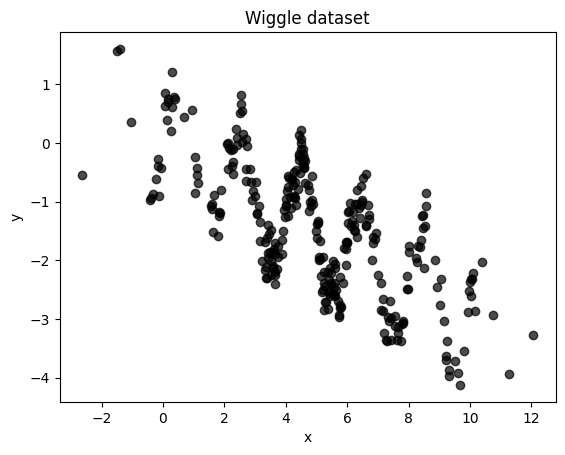

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
!pip install gpytorch
import gpytorch
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
import jax
import jax.numpy as jnp
%matplotlib inline
%load_ext autoreload
%autoreload 2
%run "utils/models.ipynb" # Run the models notebook
%run "utils/functions.ipynb" # Run the functions notebook
%run "datasets/wiggle.ipynb" # Run the wiggle notebook which is in the same folder(Wiggle dataset)


# Training Data from wiggle

In [3]:
x_wiggle, y_wiggle = x_wiggle, samples # x, samples are defined in ../datasets/wiggle.ipynb
print(len(x_wiggle))
x_train_wiggle, x_test_wiggle, y_train_wiggle, y_test_wiggle = train_test_split(x_wiggle, y_wiggle, test_size=0.2, random_state=65)
# Transform into tensors
x_train_wiggle, x_test_wiggle, y_train_wiggle, y_test_wiggle = (
torch.from_numpy(x_train_wiggle).float(), torch.from_numpy(x_test_wiggle).float(),
torch.from_numpy(y_train_wiggle).float(), torch.from_numpy(y_test_wiggle).float())

# Move to GPU if possible
x_train_wiggle, x_test_wiggle, y_train_wiggle, y_test_wiggle = (
    x_train_wiggle.to(device), x_test_wiggle.to(device), y_train_wiggle.to(device), y_test_wiggle.to(device)
)

# Different training sizes
sizes_list = [1000,2500,5000,10000,15000,20000] # Choose how many points
x_sizes = [] # List of different sized training points (x)
y_sizes = [] # List of different sized trainig points  (y)
for i in sizes_list:
  x_sizes.append(x_train_wiggle[:i])
  y_sizes.append(y_train_wiggle[:i])



training_x = x_train_wiggle[:500]
training_y = y_train_wiggle[:500]

50000


# Define the KISS-GP Model

In [4]:
KISSGP_likelihood_wiggle = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
KISSGP_mean_wiggle = gpytorch.means.ConstantMean() # Mean
KISSGP_kernel_wiggle = gpytorch.kernels.MaternKernel() # Kernel
KISSGP_model_wiggle = KISSGP(training_x,
                             training_y,
                             KISSGP_likelihood_wiggle,
                             KISSGP_mean_wiggle,
                             KISSGP_kernel_wiggle) # KISSGP defined in utils/Models.ipynb
KISSGP_model_wiggle = KISSGP_model_wiggle.to(device) # Move model to device, defined in utils/models.ipynb

# Train the KISS-GP Model

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:618.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


8.959743022918701


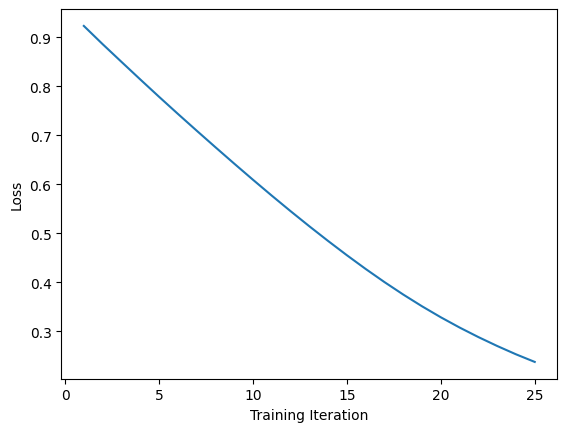

In [5]:



train_time_KISSGP_wiggle = train(KISSGP_model_wiggle,
                                 KISSGP_likelihood_wiggle,
                                 training_x, training_y,
                                 training_iter= 25) # train is defined in utils/functions.ipynb
print(train_time_KISSGP_wiggle)



# Compare Different Train Times


/usr/local/lib/python3.10/dist-packages/linear_operator/utils/sparse.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if nonzero_indices.storage():


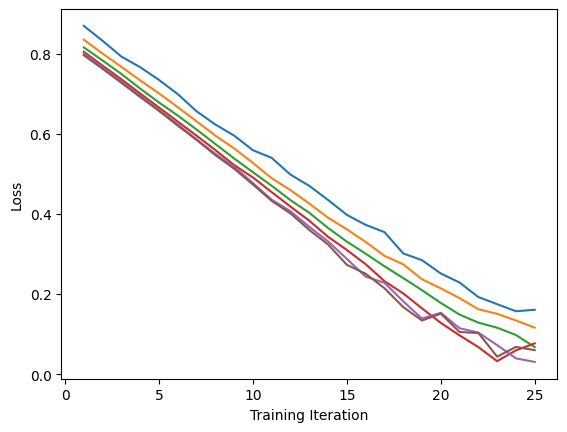

In [6]:
training_times_KISSGP = [] # Keep track of the times
for x,y  in zip(x_sizes, y_sizes):
  x,y = x.to(device), y.to(device)
  KISSGP_likelihood_wiggle_test = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
  KISSGP_mean_wiggle_test = gpytorch.means.ConstantMean() # Mean
  KISSGP_kernel_wiggle_test = gpytorch.kernels.MaternKernel() # Kernel
  KISSGP_model_wiggle_test = KISSGP(x,
                             y,
                             KISSGP_likelihood_wiggle_test,
                             KISSGP_mean_wiggle_test,
                             KISSGP_kernel_wiggle_test)

  KISSGP_model_wiggle_test = KISSGP_model_wiggle_test.to(device)
  train_time_KISSGP_wiggle_test = train(KISSGP_model_wiggle_test,
                                 KISSGP_likelihood_wiggle_test,
                                 x, y,
                                 training_iter= 25) # train is defined in utils/functions.ipynb
  training_times_KISSGP.append(train_time_KISSGP_wiggle_test)

In [7]:
print(training_times_KISSGP)

[2.8733904361724854, 16.80541753768921, 22.38822364807129, 33.34520506858826, 53.83660674095154, 76.73258638381958]


# Plot KISS-GP Model

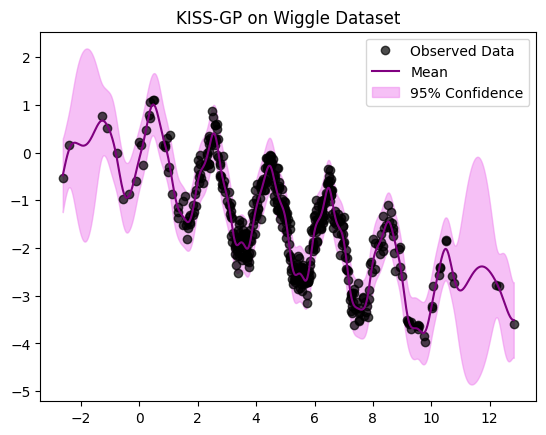

In [8]:
# plotGP defined in utils/functions.ipynb
plotGP(training_x, training_y, KISSGP_model_wiggle, KISSGP_likelihood_wiggle, "KISS-GP on Wiggle Dataset")

# Predict and Evaluate KISS-GP Model

In [9]:
# Predict
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  predictions_KISSGP_wiggle = predict(KISSGP_model_wiggle,
                                      KISSGP_likelihood_wiggle,
                                      x_test_wiggle) # predict is defined in utils/functions.ipynb

# Evaluate
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  predictions_KISSGP_wiggle = predict(KISSGP_model_wiggle, KISSGP_likelihood_wiggle,
                                     x_test_wiggle) # predict is defined in utils/functions.ipynb
  RMSE_KISSGP_wiggle, NLPD_KISSGP_wiggle, PICP_KISSGP_wiggle, MPIW_KISSGP_wiggle = error_metrics(
      x_test_wiggle,
      y_test_wiggle,
      predictions_KISSGP_wiggle.mean,
      predictions_KISSGP_wiggle.variance)# error_metrics defined in utils/functions.ipynb


  print("RMSE KISS-GP: ",RMSE_KISSGP_wiggle)
  print("NLPD KISS-GP: ",NLPD_KISSGP_wiggle)
  print("PICP KISS-GP: ",PICP_KISSGP_wiggle)
  print("MPIW KISS-GP: ",MPIW_KISSGP_wiggle)
  print("Time KISS-GP: ", train_time_KISSGP_wiggle)

RMSE KISS-GP:  0.87466925
NLPD KISS-GP:  tensor(3.5616)
PICP KISS-GP:  0.5533
MPIW KISS-GP:  1.2375221
Time KISS-GP:  8.959743022918701


# Variational Model

In [10]:
variational_likelihood_wiggle = gpytorch.likelihoods.GaussianLikelihood()
variational_mean_wiggle = gpytorch.means.ConstantMean()
variational_kernel_wiggle = gpytorch.kernels.MaternKernel()
n_inducing_points = int(len(training_x)/4) # Choose how many inducing points
inducing_points = training_x[torch.randperm(training_x.size(0))[:n_inducing_points]]
variational_model_wiggle = variationalGP(variational_likelihood_wiggle,
                                         variational_mean_wiggle,
                                         variational_kernel_wiggle,
                                         inducing_points) # .variationalGP defined in utils/models.ipynb
variational_model_wiggle = variational_model_wiggle.to(device) # Move model to device, defined in utils/models.ipynb

# Train The Variational Model

Training Time:  1.1047215461730957


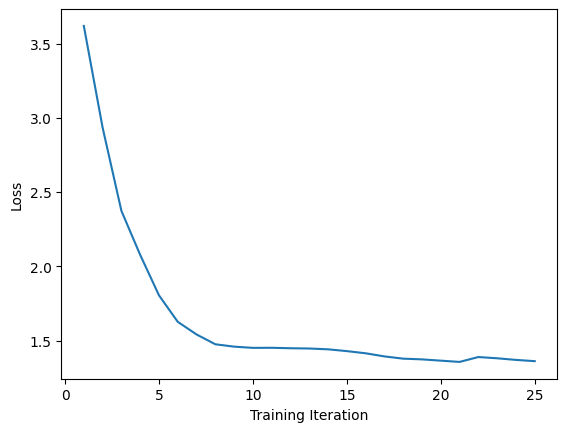

In [11]:
train_time_variational_wiggle = train_ELBO(variational_model_wiggle,
                                           variational_likelihood_wiggle,
                                           training_x, training_y,
                                           training_iter= 25) # train is defined in utils/functions.ipynb
print("Training Time: ",train_time_variational_wiggle)



# Compare Different Training Times

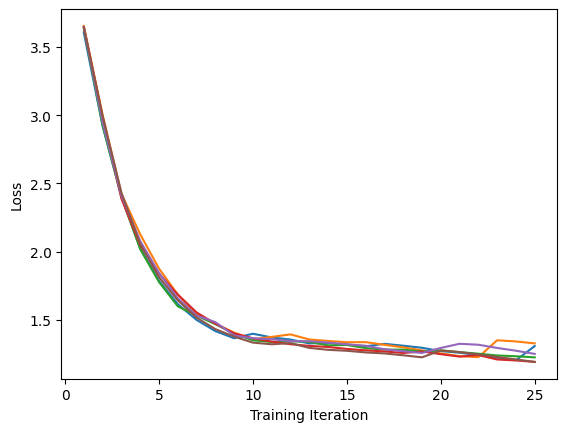

In [13]:
training_times_variational = [] # Keep track of the times
for x,y  in zip(x_sizes, y_sizes):
  n_inducing_points = int(len(x)/20) # Choose how many inducing points
  inducing_points = x[torch.randperm(x.size(0))[:n_inducing_points]]
  inducing_points = inducing_points.to(device)

  variational_likelihood_wiggle_test = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
  variational_mean_wiggle_test = gpytorch.means.ConstantMean() # Mean
  variational_kernel_wiggle_test = gpytorch.kernels.MaternKernel() # Kernel
  variational_model_wiggle_test = variationalGP(
                             variational_likelihood_wiggle_test,
                             variational_mean_wiggle_test,
                             variational_kernel_wiggle_test,
                             inducing_points)

  variational_model_wiggle_test = variational_model_wiggle_test.to(device)
  train_time_variational_wiggle_test = train_ELBO(variational_model_wiggle_test,
                                 variational_likelihood_wiggle_test,
                                 x, y,
                                 training_iter= 25) # train is defined in utils/functions.ipynb
  training_times_variational.append(train_time_variational_wiggle_test)

# Plot Variational Model

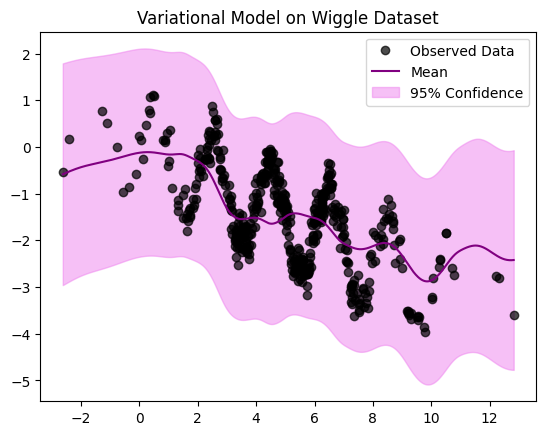

In [14]:
# plotGP defined in utils/functions.ipynb
plotGP(training_x, training_y, variational_model_wiggle, variational_likelihood_wiggle, "Variational Model on Wiggle Dataset")

# Predict and Evaluate Variational Model

In [15]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  # predict is defined in utils/functions.ipynb
  predictions_variational_wiggle = predict(variational_model_wiggle, variational_likelihood_wiggle, x_test_wiggle)

  RMSE_variational_wiggle, NLPD_variational_wiggle, PICP_variational_wiggle, MPIW_variational_wiggle = error_metrics(
      x_test_wiggle,
      y_test_wiggle,
      predictions_variational_wiggle.mean,
      predictions_variational_wiggle.variance)# error_metrics defined in utils/functions.ipynb
  print("RMSE variational Model: ",RMSE_variational_wiggle)
  print("NLPD variational Model: ",NLPD_variational_wiggle)
  print("PICP variational Model: ",PICP_variational_wiggle)
  print("MPIW variational Model: ",MPIW_variational_wiggle)
  print("Time variational Model: ", train_time_variational_wiggle)

RMSE variational Model:  0.8092568291097034
NLPD variational Model:  tensor(1.2869, dtype=torch.float64)
PICP variational Model:  0.9975
MPIW variational Model:  4.3463607296993105
Time variational Model:  1.1047215461730957


# State Space Model Optimized

In [16]:
# To do the regression in state space, we need to rearrange the datapoints in temporal order
n_test_points = len(x_test_wiggle)
all_points = jnp.concatenate([x_train_wiggle.numpy(), x_test_wiggle.numpy()])
temporal_order = jnp.argsort(all_points)

# State Space X's and Y's
ss_xs_wiggle = all_points[temporal_order]
ss_ys_wiggle = jnp.concatenate([y_train_wiggle.numpy(), jnp.nan * jnp.ones((n_test_points, ))])[temporal_order]

# Compute the equivalent SS model
t0 = min(x_train_wiggle).numpy().item()
dts_wiggle = jnp.diff(ss_xs_wiggle, prepend=t0)

In [17]:
# Calculate ell and sigma
opt_ell_wiggle, opt_sigma_wiggle, train_time_SSOP_wiggle = train_SSGP(x_train_wiggle, y_train_wiggle, x_test_wiggle, ell=1, sigma=1)

In [18]:
mfs, vfs, mps, vps, _ = kalmanFilter(ss_ys_wiggle, dts_wiggle, opt_ell_wiggle, opt_sigma_wiggle, m0=0, v0=1)
mss, vss = kalmanSmoothing(opt_ell_wiggle, dts_wiggle, mfs, vfs, mps, vps)
ssop_posterior_mean_wiggle = mss[jnp.isnan(ss_ys_wiggle)]
ssop_posterior_var_wiggle = vss[jnp.isnan(ss_ys_wiggle)]

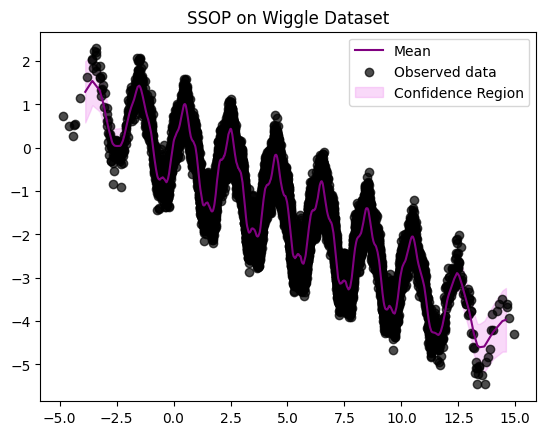

In [19]:
# Plot SSOP
plot_SSGP(x_train_wiggle, y_train_wiggle, x_test_wiggle, ssop_posterior_mean_wiggle, ssop_posterior_var_wiggle, title= "SSOP on Wiggle Dataset")

# Evaluate SSOP

In [20]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  # Order y_test, x_test
  temporal_order = jnp.argsort(x_test_wiggle.numpy())
  y_test_temporal_order = y_test_wiggle.numpy()[temporal_order]
  x_test_temporal_order = x_test_wiggle.numpy()[temporal_order]

  RMSE_SSOP_wiggle, NLPD_SSOP_wiggle, PICP_SSOP_wiggle, MPIW_SSOP_wiggle = error_metrics(
      torch.tensor(x_test_temporal_order),
      torch.tensor(y_test_temporal_order),
      torch.tensor(np.array(ssop_posterior_mean_wiggle)),
      torch.tensor(np.array(ssop_posterior_var_wiggle)))# error_metrics defined in utils/functions.ipynb
  print("RMSE SSOP Model: ",RMSE_SSOP_wiggle)
  print("NLPD SSOP Model: ",NLPD_SSOP_wiggle)
  print("PICP SSOP Model: ",PICP_SSOP_wiggle)
  print("MPIW SSOP Model: ",MPIW_SSOP_wiggle)
  print("Time SSOP Model: ", train_time_SSOP_wiggle)

RMSE SSOP Model:  0.2526053
NLPD SSOP Model:  tensor(4.3865)
PICP SSOP Model:  0.4359
MPIW SSOP Model:  0.2957999
Time SSOP Model:  1.2348554134368896


SS with PyTorch

In [22]:
# Train with pytorch instead

# Calculate ell and sigma
opt_ell_wiggle_torch, opt_sigma_wiggle_torch, train_time_SSPY_wiggle = train_SSGP_torch(training_x,
                                                                                            training_y,
                                                                                            x_test_wiggle,
                                                                                            ell=1,
                                                                                            sigma=1,
                                                                                            training_iterations=25)
# Convert them to numpy arrays
# Assume tensor is on GPU
opt_ell_wiggle_pytorch = opt_ell_wiggle_torch.to('cpu')
opt_sigma_wiggle_pytorch = opt_sigma_wiggle_torch.to('cpu')

opt_ell_wiggle_numpy = opt_ell_wiggle_pytorch.numpy()
opt_sigma_wiggle_numpy = opt_sigma_wiggle_pytorch.numpy()
# Calculate mean and variance
mfs_torch, vfs_torch, mps_torch, vps_torch, _ = kalmanFilter(ss_ys_wiggle,
                                                             dts_wiggle,
                                                             opt_ell_wiggle_numpy,
                                                             opt_sigma_wiggle_numpy,
                                                             m0=0, v0=1)
mss_torch, vss_torch = kalmanSmoothing(opt_ell_wiggle_numpy, dts_wiggle, mfs_torch, vfs_torch, mps_torch, vps_torch)
sspy_posterior_mean_wiggle = mss_torch[jnp.isnan(ss_ys_wiggle)]
sspy_posterior_var_wiggle = vss_torch[jnp.isnan(ss_ys_wiggle)]



<ipython-input-2-842d7428ac2a>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nlls.append(torch.tensor(nll, requires_grad=True))


# Compare Different Training Times

In [43]:
training_times_SS = [] # Keep track of the times
for x,y  in zip(x_sizes, y_sizes):
  x,y = x.to(device), y.to(device)

  _, _, train_time_SS_wiggle_test = train_SSGP_torch(x,
                                                    y,
                                                    x_test_wiggle,
                                                    ell=1,
                                                    sigma=1,
                                                    training_iterations=25)
  training_times_SS.append(train_time_SS_wiggle_test)

<ipython-input-2-842d7428ac2a>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nlls.append(torch.tensor(nll, requires_grad=True))


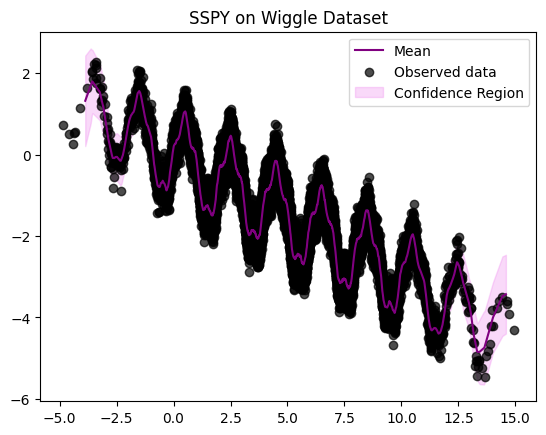

In [23]:
# Plot SSPY
plot_SSGP(x_train_wiggle, y_train_wiggle, x_test_wiggle, sspy_posterior_mean_wiggle, sspy_posterior_var_wiggle, title= "SSPY on Wiggle Dataset")

In [24]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  RMSE_SSPY_wiggle, NLPD_SSPY_wiggle, PICP_SSPY_wiggle, MPIW_SSPY_wiggle = error_metrics(
      torch.tensor(x_test_temporal_order),
      torch.tensor(y_test_temporal_order),
      torch.tensor(np.array(sspy_posterior_mean_wiggle)),
      torch.tensor(np.array(sspy_posterior_var_wiggle)))# error_metrics defined in utils/functions.ipynb
  print("RMSE SSPY Model: ",RMSE_SSPY_wiggle)
  print("NLPD SSPY Model: ",NLPD_SSPY_wiggle)
  print("PICP SSPY Model: ",PICP_SSPY_wiggle)
  print("MPIW SSPY Model: ",MPIW_SSPY_wiggle)
  print("Time SSPY Model: ", train_time_SSPY_wiggle)

RMSE SSPY Model:  0.251198
NLPD SSPY Model:  tensor(1.5795)
PICP SSPY Model:  0.596
MPIW SSPY Model:  0.42830265
Time SSPY Model:  46.50202012062073


# State Space Model, without optimizer

In [25]:
# Pick hyperparameters on your own:
ell = 3
sigma = 1

start_time = time.time()
mfs2, vfs2, mps2, vps2, _ = kalmanFilter(ss_ys_wiggle, dts_wiggle, ell, sigma, m0=0, v0=1)
mss2, vss2 = kalmanSmoothing(ell, dts_wiggle, mfs2, vfs2, mps2, vps2)
sswo_posterior_mean_wiggle = mss2[jnp.isnan(ss_ys_wiggle)]
sswo_posterior_var_wiggle = vss2[jnp.isnan(ss_ys_wiggle)]
end_time = time.time()
train_time_SSWO_wiggle = end_time-start_time

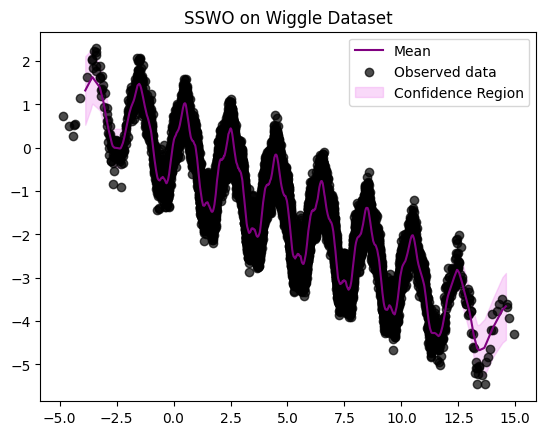

In [26]:
plot_SSGP(x_train_wiggle, y_train_wiggle, x_test_wiggle, sswo_posterior_mean_wiggle, sswo_posterior_var_wiggle, title= "SSWO on Wiggle Dataset")

# Evaluate SSWO

In [27]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():

  RMSE_SSWO_wiggle, NLPD_SSWO_wiggle, PICP_SSWO_wiggle, MPIW_SSWO_wiggle = error_metrics(
      torch.tensor(x_test_temporal_order),
      torch.tensor(y_test_temporal_order),
      torch.tensor(np.array(sswo_posterior_mean_wiggle)),
      torch.tensor(np.array(sswo_posterior_var_wiggle)))# error_metrics defined in utils/functions.ipynb
  print("RMSE SSWO Model: ",RMSE_SSWO_wiggle)
  print("NLPD SSWO Model: ",NLPD_SSWO_wiggle)
  print("PICP SSWO Model: ",PICP_SSWO_wiggle)
  print("MPIW SSWO Model: ",MPIW_SSWO_wiggle)
  print("Time SSWO Model: ", train_time_SSWO_wiggle)

RMSE SSWO Model:  0.25186053
NLPD SSWO Model:  tensor(3.4311)
PICP SSWO Model:  0.4761
MPIW SSWO Model:  0.3250405
Time SSWO Model:  0.26390886306762695


# Inducing Points Model

In [28]:
inducing_likelihood_wiggle = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
inducing_mean_wiggle = gpytorch.means.ConstantMean() # Mean
inducing_kernel_wiggle = gpytorch.kernels.MaternKernel() # Kernel
# Choose random inital inducing points
# Generate a tensor of random indices
indices = torch.randperm(training_x.size(0))
# Select N random rows
inducing_points_amount = int(len(training_x)/4) # Choose how many inducing points
inducing_points = training_x[indices][:inducing_points_amount]
inducing_model_wiggle = inducingGP(training_x,
                                 training_y,
                                 inducing_likelihood_wiggle,
                                 inducing_mean_wiggle,
                                 inducing_kernel_wiggle,
                                 inducing_points) # inducingGP defined in utils/Models.ipynb

# Train Inducing Points Model

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


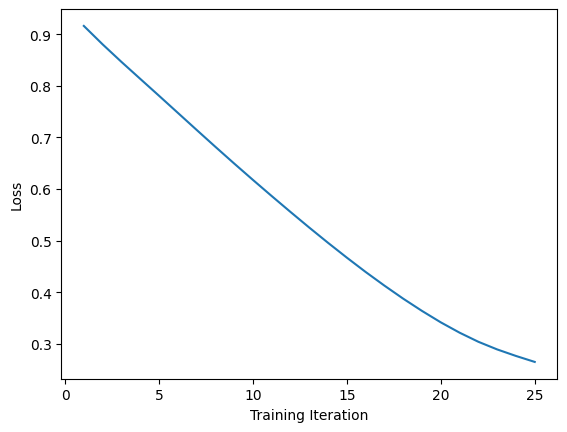

In [29]:
train_time_inducing_wiggle = train(inducing_model_wiggle,
                          inducing_likelihood_wiggle,
                          training_x,
                          training_y,
                          training_iter= 25) # train is defined in utils/functions.ipynb

# Compare Different Training Times

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


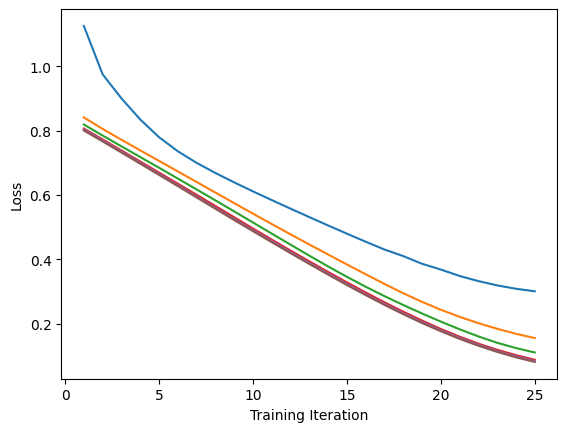

In [31]:
training_times_inducing = [] # Keep track of the times
for x,y  in zip(x_sizes, y_sizes):
  inducing_points_amount = int(len(x)/20) # Choose how many inducing points
  inducing_points = x[indices][:inducing_points_amount]
  x,y = x.to(device), y.to(device)

  inducing_likelihood_wiggle_test = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
  inducing_mean_wiggle_test = gpytorch.means.ConstantMean() # Mean
  inducing_kernel_wiggle_test = gpytorch.kernels.MaternKernel() # Kernel
  inducing_model_wiggle_test = inducingGP(x,
                             y,
                             inducing_likelihood_wiggle_test,
                             inducing_mean_wiggle_test,
                             inducing_kernel_wiggle_test,
                             inducing_points)

  inducing_model_wiggle_test = inducing_model_wiggle_test.to(device)
  train_time_inducing_wiggle_test = train(inducing_model_wiggle_test,
                                 inducing_likelihood_wiggle_test,
                                 x, y,
                                 training_iter= 25) # train is defined in utils/functions.ipynb
  training_times_inducing.append(train_time_inducing_wiggle_test)

# Plot Inducing Points Model

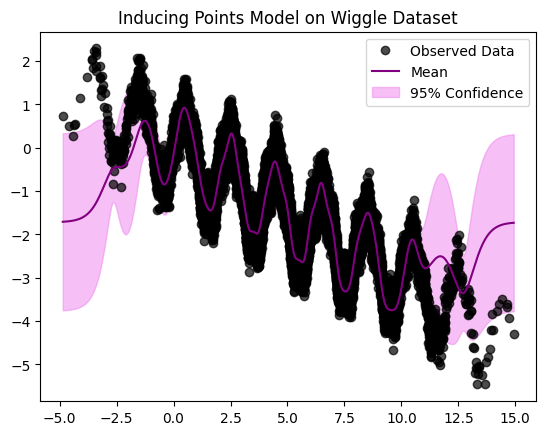

In [32]:
# plotGP defined in utils/functions.ipynb
plotGP(x_train_wiggle, y_train_wiggle, inducing_model_wiggle, inducing_likelihood_wiggle, "Inducing Points Model on Wiggle Dataset")

# Predict and Evaluate Inducing Points Model

In [33]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  predictions_inducing_wiggle = predict(inducing_model_wiggle, inducing_likelihood_wiggle,
                                     x_test_wiggle) # predict is defined in utils/functions.ipynb
  RMSE_inducing_wiggle, NLPD_inducing_wiggle, PICP_inducing_wiggle, MPIW_inducing_wiggle = error_metrics(
      x_test_wiggle,
      y_test_wiggle,
      predictions_inducing_wiggle.mean,
      predictions_inducing_wiggle.variance)# error_metrics defined in utils/functions.ipynb



  print("RMSE inducing: ",RMSE_inducing_wiggle)
  print("NLPD inducing: ",NLPD_inducing_wiggle)
  print("PICP inducing: ",PICP_inducing_wiggle)
  print("MPIW inducing: ",MPIW_inducing_wiggle)
  print("Time inducing: ", train_time_inducing_wiggle)

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


RMSE inducing:  0.32602555
NLPD inducing:  tensor(0.1759)
PICP inducing:  0.9663
MPIW inducing:  1.2278961
Time inducing:  0.44426679611206055


# Display Results

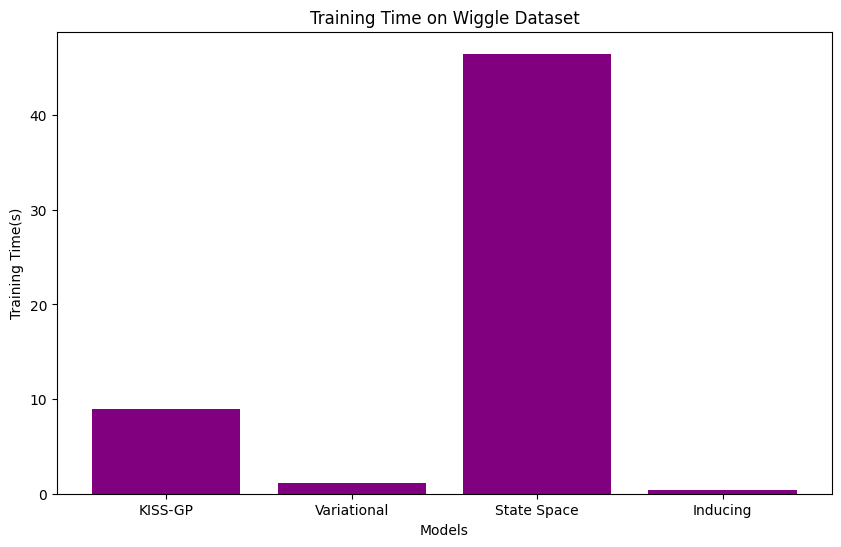

In [34]:
# Training times
models = ["KISS-GP", "Variational", "State Space", "Inducing"]
times_wiggle = [train_time_KISSGP_wiggle, train_time_variational_wiggle, train_time_SSPY_wiggle, train_time_inducing_wiggle]
plot_bar(models, times_wiggle, "Training Time on Wiggle Dataset", "Models", "Training Time(s)") # plot_bar defined in utils/function.ipynb

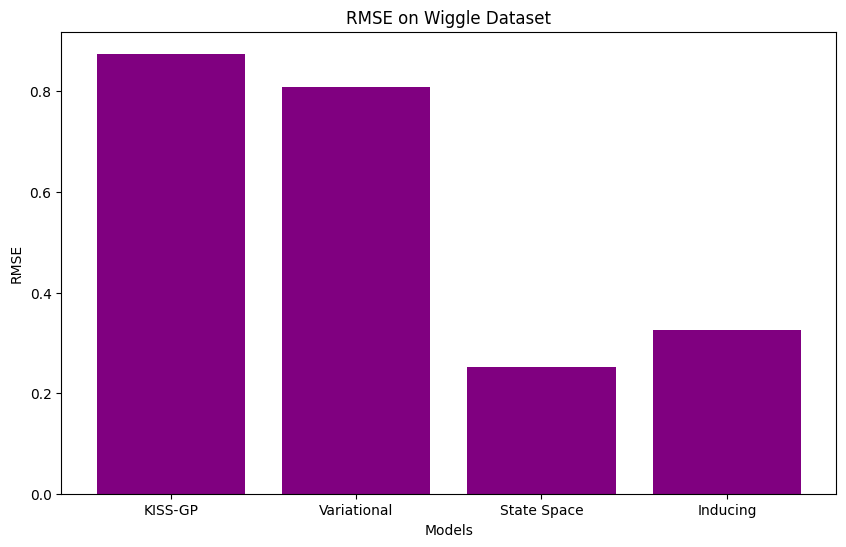

In [35]:
# RMSE
models = ["KISS-GP", "Variational", "State Space", "Inducing"]
RMSE_wiggle = [RMSE_KISSGP_wiggle, RMSE_variational_wiggle, RMSE_SSPY_wiggle, RMSE_inducing_wiggle]
plot_bar(models, RMSE_wiggle, "RMSE on Wiggle Dataset", "Models", "RMSE") # plot_bar defined in utils/function.ipynb

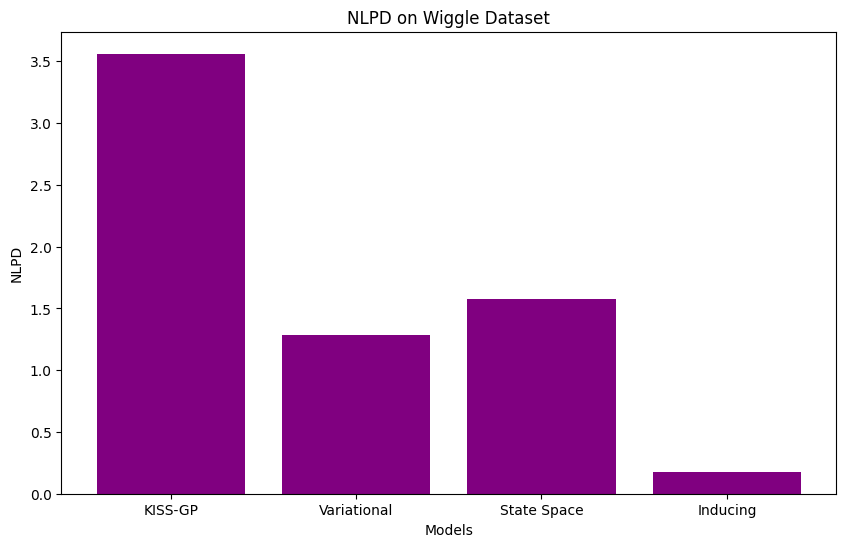

In [36]:
# NLPD
models = ["KISS-GP", "Variational", "State Space", "Inducing"]
NLPD_wiggle = [NLPD_KISSGP_wiggle, NLPD_variational_wiggle, NLPD_SSPY_wiggle, NLPD_inducing_wiggle]
plot_bar(models, NLPD_wiggle, "NLPD on Wiggle Dataset", "Models", "NLPD") # plot_bar defined in utils/function.ipynb

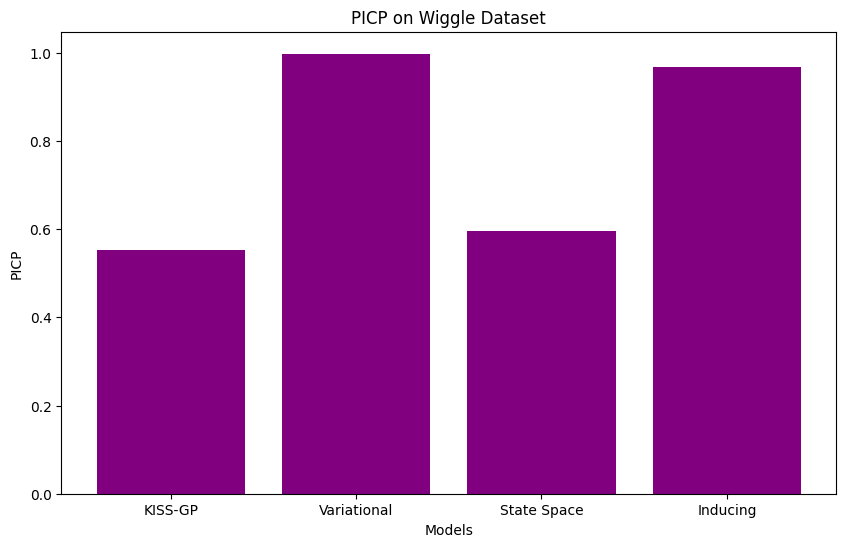

In [37]:
# PICP
models = ["KISS-GP", "Variational", "State Space", "Inducing"]
PICP_wiggle = [PICP_KISSGP_wiggle, PICP_variational_wiggle, PICP_SSPY_wiggle, PICP_inducing_wiggle]
plot_bar(models, PICP_wiggle, "PICP on Wiggle Dataset", "Models", "PICP") # plot_bar defined in utils/function.ipynb


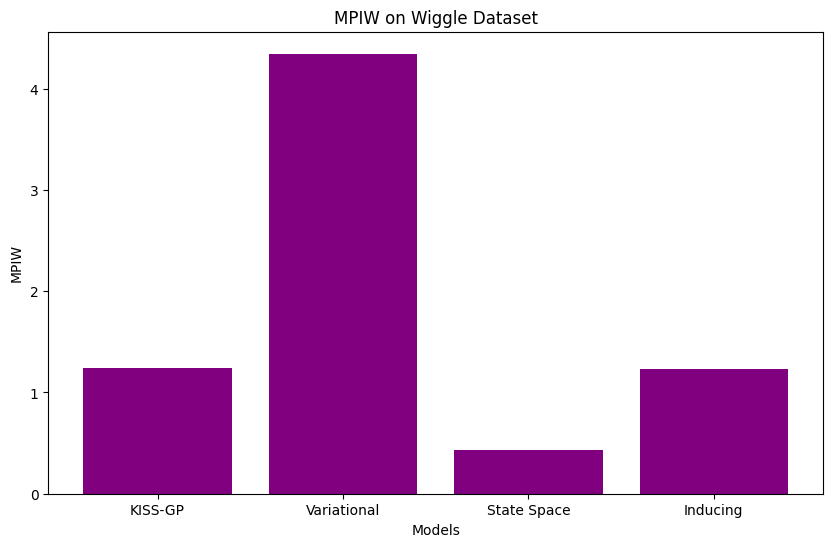

In [38]:
# MPIW
models = ["KISS-GP", "Variational", "State Space", "Inducing"]
MPIW_wiggle = [MPIW_KISSGP_wiggle, MPIW_variational_wiggle, MPIW_SSPY_wiggle, MPIW_inducing_wiggle]
plot_bar(models, MPIW_wiggle, "MPIW on Wiggle Dataset", "Models", "MPIW") # plot_bar defined in utils/function.ipynb

# Summarize for report

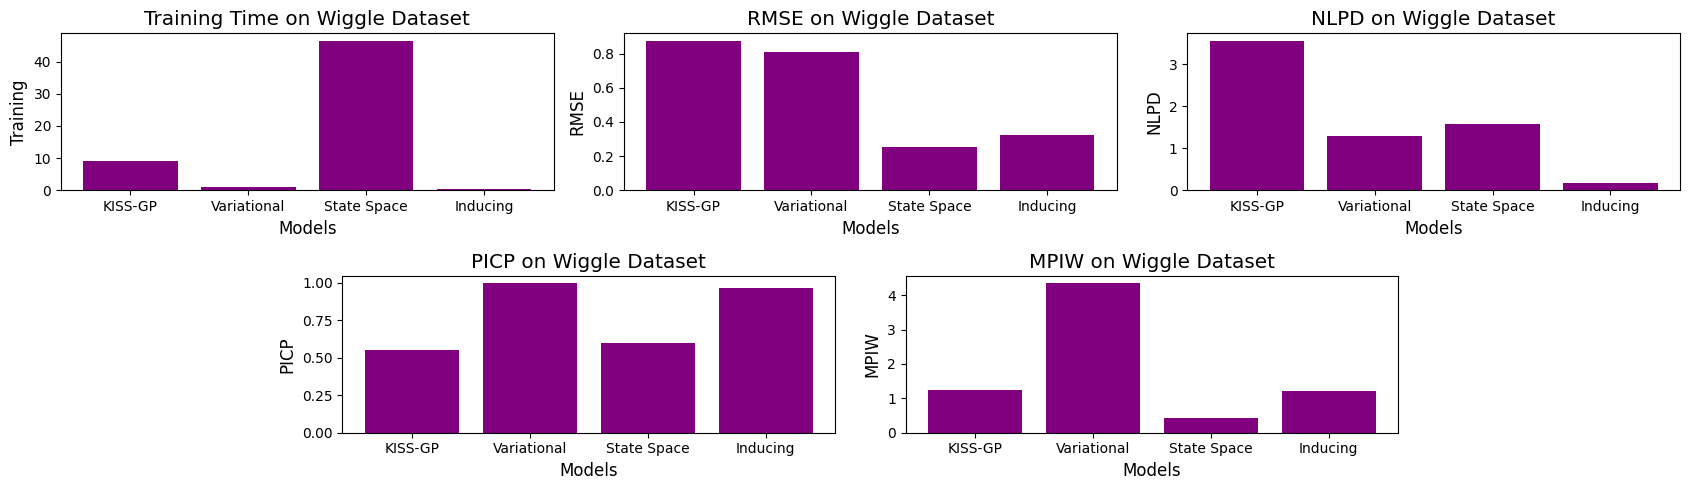

In [39]:
from matplotlib.gridspec import GridSpec

gs = GridSpec(2, 6)  # 2 rows, 6 columns

fig = plt.figure(figsize=(17, 5))

# Create subplots
ax1 = fig.add_subplot(gs[0, 0:2])  # Spans columns 0-1
ax2 = fig.add_subplot(gs[0, 2:4])  # Spans columns 2-3
ax3 = fig.add_subplot(gs[0, 4:6])  # Spans columns 4-5
ax4 = fig.add_subplot(gs[1, 1:3])  # Spans columns 1-2
ax5 = fig.add_subplot(gs[1, 3:5])  # Spans columns 3-4

axes = [ax1, ax2, ax3, ax4, ax5]  # List of axes
data = [times_wiggle, RMSE_wiggle, NLPD_wiggle, PICP_wiggle, MPIW_wiggle]  # Replace with your data
titles = ["Training Time on Wiggle Dataset", "RMSE on Wiggle Dataset", "NLPD on Wiggle Dataset", "PICP on Wiggle Dataset", "MPIW on Wiggle Dataset"]

# Plot data
for i, ax in enumerate(axes):
    ax.bar(models, data[i], color='purple')
    ax.set_title(titles[i], size = "x-large")
    ax.set_xlabel("Models", size = "large")
    ax.set_ylabel(titles[i].split(" ")[0], size = "large")

plt.tight_layout()
plt.savefig("metrics_wiggle")
plt.show()

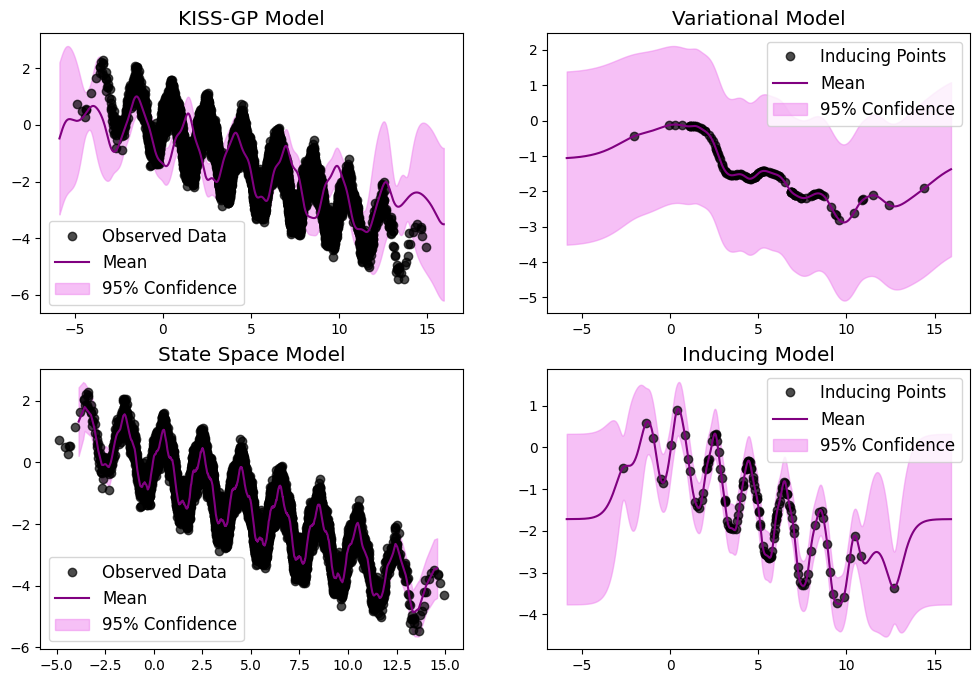

In [40]:
# Initalize plot
plt.style.use('default')
# Create a figure and a set of subplots
fig, ax = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

# Find min and max value of training set
min_value, max_value = min(x_train_wiggle), max(x_train_wiggle)
# Create points between min and max values
x_plot = torch.linspace(min_value-1, max_value+1, 1000)


# KISS-GP
# Evaluate on plot values
prediction = predict(KISSGP_model_wiggle, KISSGP_likelihood_wiggle, x_plot)
mean_KISSGP = prediction.mean
var_KISSGP = prediction.variance
lower_bound_KISSGP = mean_KISSGP-(1.96*(np.sqrt(var_KISSGP)))
upper_bound_KISSGP = mean_KISSGP+(1.96*(np.sqrt(var_KISSGP)))
ax[0,0].plot(x_train_wiggle, y_train_wiggle, 'ko', label='Observed Data', alpha = 0.7)
# Plot predictive means
ax[0,0].plot(x_plot.detach().numpy(), mean_KISSGP.detach().numpy(), 'purple', label='Mean')
# Plot confidence bounds as lightly shaded region
ax[0,0].fill_between(x_plot.detach().numpy(), lower_bound_KISSGP.detach().numpy(),
                upper_bound_KISSGP.detach().numpy(), alpha=0.5, color="violet", zorder=-1, label ='95% Confidence')
ax[0,0].set_title("KISS-GP Model", fontsize="x-large")
ax[0,0].legend(loc = "best", fontsize="large")


# Variational Model
trained_variational_points_x = variational_model_wiggle.variational_strategy.inducing_points
trained_variational_points_y = predict(variational_model_wiggle, variational_likelihood_wiggle,
                                     trained_variational_points_x) # predict is defined in utils/functions.ipynb¨

with torch.no_grad(), gpytorch.settings.fast_pred_var():
  # Evaluate on plot values
  prediction = predict(variational_model_wiggle, variational_likelihood_wiggle, x_plot)
  mean_variational = prediction.mean
  var_variational = prediction.variance
  lower_bound_variational = mean_variational-(1.96*(np.sqrt(var_variational)))
  upper_bound_variational = mean_variational+(1.96*(np.sqrt(var_variational)))
  ax[0,1].plot(trained_variational_points_x.numpy(), trained_variational_points_y.mean.numpy(), 'ko', label='Inducing Points', alpha = 0.7)
  # Plot predictive means
  ax[0,1].plot(x_plot.detach().numpy(), mean_variational.detach().numpy(), 'purple', label='Mean')
  # Plot confidence bounds as lightly shaded region
  ax[0,1].fill_between(x_plot.detach().numpy(), lower_bound_variational.detach().numpy(),
                  upper_bound_variational.detach().numpy(), alpha=0.5, color="violet", zorder=-1, label ='95% Confidence')
  ax[0,1].set_title("Variational Model", fontsize="x-large")
  ax[0,1].legend(loc = "best", fontsize="large")





# Find min and max value of training set
temporal_order = jnp.argsort(x_test_wiggle.numpy())
x_test_order = x_test_wiggle.numpy()[temporal_order]
lower_bound_SS = sspy_posterior_mean_wiggle-(1.96*(np.sqrt(sspy_posterior_var_wiggle)))
upper_bound_SS = sspy_posterior_mean_wiggle+(1.96*(np.sqrt(sspy_posterior_var_wiggle)))
ax[1,0].plot(x_train_wiggle, y_train_wiggle, 'ko', label='Observed Data', alpha = 0.7)
# Plot predictive means
ax[1,0].plot(x_test_order, sspy_posterior_mean_wiggle, 'purple', label='Mean')
# Plot confidence bounds as lightly shaded region
ax[1,0].fill_between(x_test_order, lower_bound_SS,
                upper_bound_SS, alpha=0.5, color="violet", zorder=-1, label ='95% Confidence')
ax[1,0].set_title("State Space Model", fontsize="x-large")
ax[1,0].legend(loc = "best", fontsize="large")



# Inducing Model
trained_inducing_points_x = inducing_model_wiggle.covar_module.inducing_points
trained_inducing_points_y = predict(inducing_model_wiggle, inducing_likelihood_wiggle,
                                     trained_inducing_points_x) # predict is defined in utils/functions.ipynb¨

inducing_model_wiggle.eval(), inducing_likelihood_wiggle.eval()
# Evaluate on plot values
prediction = inducing_likelihood_wiggle(inducing_model_wiggle(x_plot))
inducing_model_wiggle.train(), inducing_likelihood_wiggle.train()
mean_inducing = prediction.mean
var_inducing = prediction.variance
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  lower_bound_inducing = mean_inducing-(1.96*(np.sqrt(var_inducing)))
  upper_bound_inducing = mean_inducing+(1.96*(np.sqrt(var_inducing)))
  ax[1,1].plot(trained_inducing_points_x.numpy(), trained_inducing_points_y.mean.numpy(), 'ko', label='Inducing Points', alpha = 0.7)
  # Plot predictive means
  ax[1,1].plot(x_plot.detach().numpy(), mean_inducing.detach().numpy(), 'purple', label='Mean')
  # Plot confidence bounds as lightly shaded region
  ax[1,1].fill_between(x_plot.detach().numpy(), lower_bound_inducing.detach().numpy(),
                  upper_bound_inducing.detach().numpy(), alpha=0.5, color="violet", zorder=-1, label ='95% Confidence')
  ax[1,1].set_title("Inducing Model", fontsize="x-large")
  ax[1,1].legend(loc = "best", fontsize="large")


plt.savefig("models_wiggle")

# Plot The Training Times

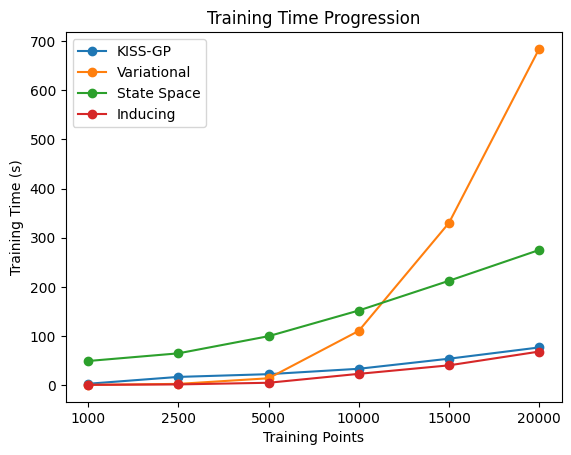

In [45]:
# Plot each array of training times
plt.plot(training_times_KISSGP, marker='o', label='KISS-GP')
plt.plot(training_times_variational, marker='o', label='Variational')
plt.plot(training_times_SS, marker='o', label='State Space')
plt.plot(training_times_inducing, marker='o', label='Inducing')

# Add labels and title
plt.xlabel('Training Points')
plt.ylabel('Training Time (s)')
plt.title('Training Time Progression')

plt.xticks(range(len(sizes_list)), sizes_list)


# Add a legend to explain which line corresponds to which array
plt.legend()

# Show the plot
#plt.savefig("training_comparison.pdf")
plt.show()